# Implementation of matrix factorization using SVD for getting recommendations.

## Imports

In [1]:
import sys
sys.path.append("../")

In [76]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import typing as tp
import numpy as np
from tqdm import tqdm
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from concurrent.futures import ThreadPoolExecutor
from rectools.models import PureSVDModel
from rectools.dataset import Dataset
import datetime
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from src.utils import rec_imaging

## Data preparation

In [3]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [4]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [5]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [6]:
interactions = interactions[interactions["item_name"].notna()]
interactions = interactions[interactions["score"] > 0]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [7]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "score": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)

## Model

In [8]:
interactions = interactions.rename(columns={"score": "weight"})

In [9]:
interactions["datetime"] = datetime.datetime.today()

In [10]:
dataset = Dataset.construct(interactions_df=interactions[["user_id", "item_id", "weight", "datetime"]])

In [11]:
model = PureSVDModel()

In [12]:
model.fit(dataset)

In [13]:
interactions.user_id.unique()

array([    0,     1,     2, ..., 68088, 68089, 68090])

In [14]:
model.recommend(
    users=interactions.user_id.unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False    
)

,user_id,item_id,score,rank
0,0,138893,0.001050,1
1,0,143784,0.001044,2
2,0,139266,0.001042,3
3,0,136265,0.001040,4
4,0,137132,0.001040,5
...,...,...,...,...
680905,68090,46425,0.038047,6
680906,68090,4131,0.037430,7
680907,68090,51799,0.037284,8
680908,68090,50045,0.033635,9


In [103]:
class SVD:
    def __init__(
        self,
        interactions_df: pd.DataFrame,
        d: int
    ) -> None:
        self.content_dict = {}
        self.interactions_df = interactions_df

        # Fill dict with content
        for i, j, k in self.interactions_df[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        self.rates_cnt = self.interactions_df.shape[0]

        # Create matrix in COO format
        self.rates: coo_matrix = coo_matrix(
            (
                self.interactions_df["weight"],
                (self.interactions_df["user_id"], self.interactions_df["item_id"])
            ),
            shape=(len(set(self.interactions_df["user_id"])), len(set(self.interactions_df["item_id"])))
        )

        self.P = np.random.rand(self.rates.shape[0], d)
        self.Q = np.random.rand(d, self.rates.shape[1])

    def SVD(
        self,
        d: int = 10,
        n_iters: int = 10,
        step: float = 0.01
    ) -> tp.List[float]:
        """Makes SVD decomposition and get latent representations of users and items."""

        P = np.random.rand(self.rates.shape[0], d)
        Q = np.random.rand(d, self.rates.shape[1])

        losses = []
        self.rates = self.rates.toarray()
        start_mse = self.MSE_Loss(P, Q)
        losses.append(start_mse)

        for _ in tqdm(range(n_iters)):
            idx = np.random.randint(0, self.rates_cnt)
            user_id = self.interactions_df.iloc[idx]["user_id"]
            item_id = self.interactions_df.iloc[idx]["item_id"]
            
            for k in range(0, d):
                P[user_id, k] = P[user_id, k] + step * (self.rates[user_id][item_id] - P[user_id, :] @ Q[:, item_id]) * Q[k, item_id] 
                Q[k, item_id] = Q[k, item_id] + step * (self.rates[user_id][item_id] - P[user_id, :] @ Q[:, item_id]) * P[user_id, k] 

            mse = self.MSE_Loss(P, Q)
            losses.append(mse)
        
        self.user_embeddings = P
        self.item_embeddings = Q

        return losses

    def MSE_Loss(
        self,
        U: np.ndarray,
        V: np.ndarray,
    ) -> float:
        """
        Calculates Mean Squared Error loss.
        
        Function calculates MSE Loss only for rated items.
        """
        mse = 0
        
        for i in range(self.rates_cnt):
            user_id = self.interactions_df.iloc[i]["user_id"]
            item_id = self.interactions_df.iloc[i]["item_id"]
            mse += (self.rates[user_id][item_id] - np.dot(U[user_id, :], V[:, item_id])) ** 2 / self.rates_cnt

        return mse

    def MSE_Loss_parallel(
        self,
        U: np.ndarray,
        V: np.ndarray,
        i: int
    ) -> float:
        """
        Calculates Mean Squared Error loss.
        
        Function calculates MSE Loss only for rated items.
        """
        pass # TODO: doesn't work properly yet
        # MAX_CPU = multiprocessing.cpu_count()
        # part = model.rates_cnt // MAX_CPU
        # i_split = i
        # if i_split != MAX_CPU - 1:
        #     rates_slice = self.interactions_df.iloc[part * i_split:part * (i_split + 1)]
        # else:
        #     rates_slice = self.interactions_df.iloc[part * i_split:]

        # mse = 0
        # self.rates = self.rates.toarray()
        # for i in tqdm(range(rates_slice.shape[0])):
        #     user_id = self.interactions_df.iloc[i]["user_id"]
        #     item_id = self.interactions_df.iloc[i]["item_id"]
        #     mse += (self.rates[user_id][item_id] - np.dot(U[user_id, :], V[:, item_id])) ** 2 / rates_slice.shape[0]

        return mse

    def get_i2i_rec(
        self,
        i: int
    ) -> None:
        metrics = cosine_similarity(self.item_embeddings[0].reshape(1, -1), self.item_embeddings)
        print("For item:")
        rec_imaging([i], self.content_dict)
        print("Such recommendations:")
        rec_imaging(
            np.argsort(-metrics)[0][1:11],
            self.content_dict,
            -np.round(np.sort(-metrics)[0][1:11], 4)
        )

In [104]:
model = SVD(interactions, d=5)

In [105]:
losses = model.SVD()

100%|██████████| 10/10 [03:32<00:00, 21.24s/it]


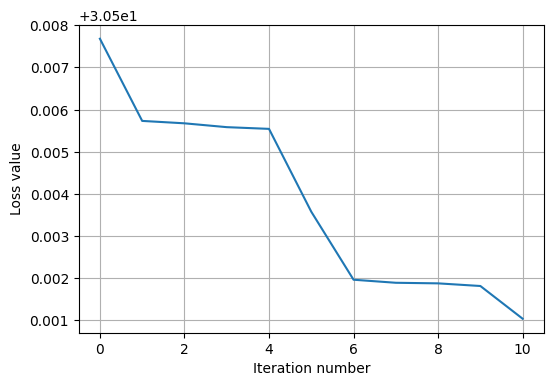

In [106]:
fig = plt.figure(figsize=(6, 4))
plt.xlabel("Iteration number")
plt.ylabel("Loss value")
plt.grid()
plt.plot(losses)

## View recommendations

In [108]:
HARRY_ID = 46425
HOBBIT_ID = 24535

For item:


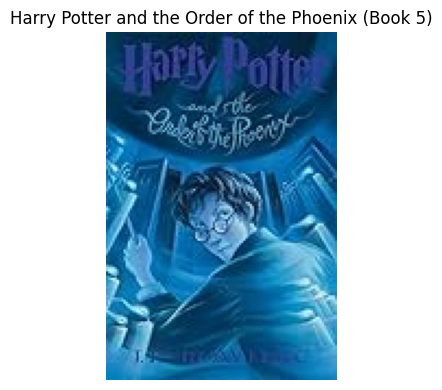

Such recommendations:


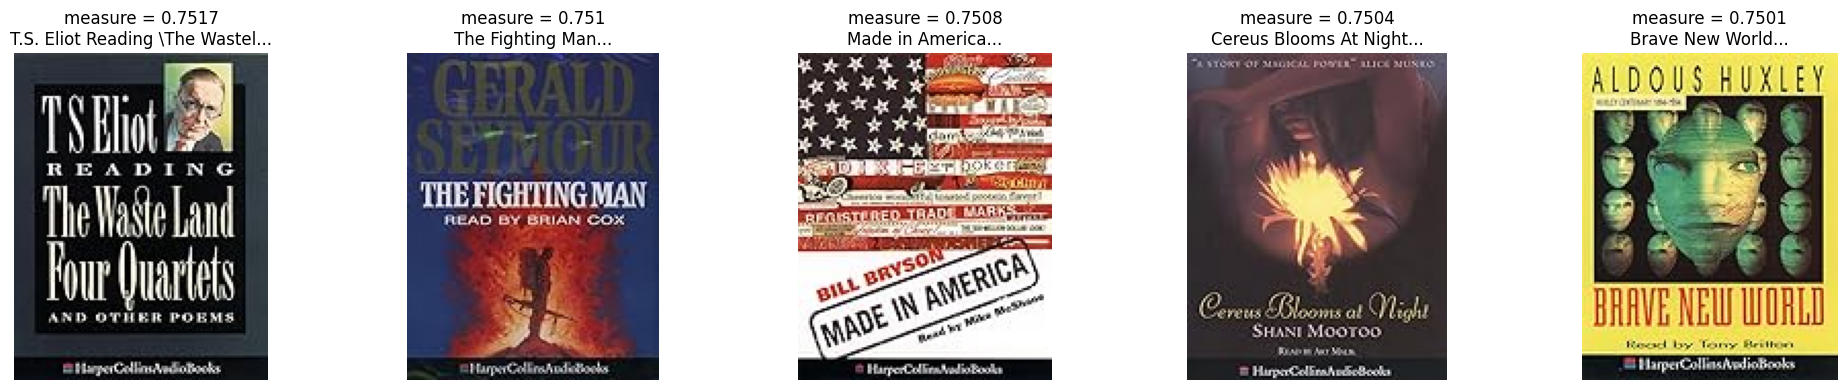

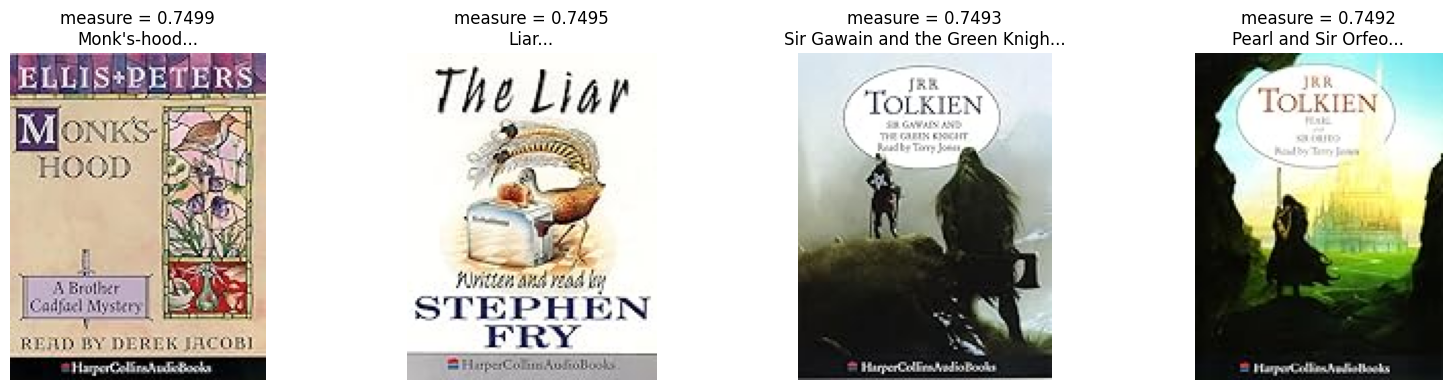

In [109]:
model.get_i2i_rec(HARRY_ID)